In [1]:
H = 448
W = 448

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            # kernel_size=3: 3x3 filter to process the input.
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            # mid channels for more complex patterns, moving from simple edges (early layers) to higher-level features (middle layers) before reaching the final output
            nn.BatchNorm2d(mid_channels),

            # the filter (or kernel) in a convolutional layer is typically followed by an activation function like ReLU
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    # A 2x2 max pooling operation with a stride of 2 will reduce each 2x2 block of the input feature map to a single value.

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            # 2: This is the size of the pooling window 2x2, moves across the input and takes the maximum value from each 2x2 block.
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            # It enlarges the input feature map or image. Imagine stretching a picture to make it bigger.
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            # increases the size of the input feature maps. But it does so with learned parameters, 
            # meaning it can adapt and learn how to best increase the size during training.
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    # x2 > x1 in spatial dimensions (h + w), because x1 is being padded to match the size of x2 before concatenation
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down_64_to_128 = Down(64, 128)
        self.down_128_to_256 = Down(128, 256)
        self.down_256_to_512 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down_512_to_1024 = Down(512, 1024 // factor)
        self.up_1024_to_512 = Up(1024, 512 // factor, bilinear)
        self.up_512_to_256 = Up(512, 256 // factor, bilinear)
        self.up_256_to_128 = Up(256, 128 // factor, bilinear)
        self.up_128_to_64 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down_64_to_128(x1)
        x3 = self.down_128_to_256(x2)
        x4 = self.down_256_to_512(x3)
        x5 = self.down_512_to_1024(x4)
        x = self.up_1024_to_512(x5, x4)
        x = self.up_512_to_256(x, x3)
        x = self.up_256_to_128(x, x2)
        x = self.up_128_to_64(x, x1)
        logits = self.outc(x)
        return logits

In [3]:
from collections import namedtuple
import matplotlib.colors as colors
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
Label = namedtuple( 'Label' , ['name' ,'id','color'] )
labels = [
    Label(  'ground'  ,  0 ,  (0,  0,  0)     ),
    Label(  'crack'   ,  1 ,  (255, 255, 255) )
]

max_label_id = max([l.id for l in labels])

# turn to arr of numbers between 0 to 1
LabelCmap = colors.ListedColormap([np.array(l.color) / 255 for l in labels])
bounds = np.linspace(0, max_label_id, len(labels))

def display(display_list):
  fig, cols = plt.subplots(1, len(display_list), sharey=True)
  fig.set_size_inches(15, 5)
  title = ['Input Image', 'Ground-truth Labels', 'Stage 1 Prediction Labels']
  im = None
  for i in range(len(display_list)):
    cols[i].set_title(title[i])
    y = display_list[i]
    
    if 'Label' in title[i]:
      w,h,_ = y.shape
      y = y.reshape(w,h)
      im = cols[i].imshow(y, cmap=LabelCmap, vmin=0, vmax=max_label_id)
    else:
      im = cols[i].imshow(tf.keras.preprocessing.image.array_to_img(y)) # this look better
      #im = cols[i].imshow(y)
    cols[i].axis('off')
  cbar = plt.colorbar(im, ax=cols.ravel().tolist(), cmap=LabelCmap, norm=colors.BoundaryNorm(bounds, LabelCmap.N), 
                      orientation='horizontal',spacing='proportional', ticks=bounds, boundaries=bounds, format='%1i')
  cbar.ax.set_xticklabels([l.name for l in labels], rotation=90)
  plt.show()

# Plotting Loss, IoU, and Correct in separate subplots
def plot_metrics(mode, loss_history, iou_history, correct_history):
    # print(loss_history)
    # print(iou_history)
    # print(correct_history)
    epochs = range(1, len(loss_history) + 1)

    # Create subplots: 1 row, 3 columns
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

    # Plot Loss
    ax1.plot(epochs, np.array(loss_history), color='tab:blue', label='Loss')
    ax1.set_title(f"{mode} Loss Over Epochs")
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.legend()

    # Plot IoU
    #print(iou_history)
    ax2.plot(epochs, [iou.cpu().numpy() for iou in iou_history], color='tab:green', label='IoU')
    ax2.set_title(f"{mode} IoU Over Epochs")
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('IoU')
    ax2.tick_params(axis='y', labelcolor='tab:green')
    ax2.legend()

    # Plot Correct Predictions
    ax3.plot(epochs, np.array(correct_history), color='tab:red', label='Correct Predictions')
    ax3.set_title(f"{mode} Correct Predictions Over Epochs")
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('Correct Predictions')
    ax3.tick_params(axis='y', labelcolor='tab:red')
    ax3.legend()

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Display the plots
    plt.show()

In [4]:
from torchvision import transforms, datasets
import os
import os.path as osp
import random
from glob import glob
from PIL import Image
import scipy.io as scio
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import cv2
from PIL import Image

class CrackDataSet(torch.utils.data.Dataset):
    # data[0] is image, data[1] is mask
    def __init__(self, data, data_transforms):
        self.data_transforms = data_transforms
        self.data = data
        
    def __len__(self):
        return len(self.data[0]) # images size
        
    def __getitem__(self, index):
        # OpenCV's default = BGR => RGB and then adding normalization here
        image = cv2.imread(self.data[0][index], cv2.IMREAD_COLOR)
        image = self.data_transforms(Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype('uint8'), 'RGB'))

        # masks are black and white images, so pixels closer to 255 consider = crack = label them
        mask = cv2.imread(self.data[1][index], cv2.IMREAD_GRAYSCALE)
        mask_label = np.zeros(mask.shape)
        mask_label[mask >= 128] = 1
        mask_label = np.asarray(mask_label, np.compat.long)
        mask_label = torch.LongTensor(mask_label)
        return image, mask_label

In [5]:
import argparse
import os
import time
import pandas as pd
import torch.optim as optim
from torch import nn
from torch.utils.data import DataLoader
from torchvision.transforms import ToPILImage
from tqdm import tqdm
from torchmetrics import JaccardIndex
import shutil
from torchvision import models
from torchsummary import summary


def load_data(path=''):
    images = sorted(glob(os.path.join(path, "images/*")))
    masks = sorted(glob(os.path.join(path, "masks/*")))
    train_x, valid_x, train_y, valid_y = train_test_split(images, masks, test_size=0.2, random_state=42)
    return (train_x, train_y), (valid_x, valid_y)


class Trainer_Wrapper():
    def __init__(self, model, input_path, batch_size, max_epochs, num_class=5):
        self.num_class = num_class
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.batch_size = batch_size
        self.epoch = 1  # An epoch in machine learning is one complete pass through the entire training dataset during the training process
        self.max_epochs = max_epochs
        self.lr = 0.001  # Learning rate for the optimizer
        data_train, data_eval = load_data(path=input_path)
        self.image_datasets = {
            'train':
                CrackDataSet(data_train, data_transforms['train']),
            'validation':
                CrackDataSet(data_eval, data_transforms['validation'])
        }
        # create dataloader to read batch_size of items for training
        # when training, images should be choose random, so shuffle = True
        self.train_loader = torch.utils.data.DataLoader(self.image_datasets['train'],
                                                        batch_size=batch_size,
                                                        shuffle=True)
        self.val_loader = torch.utils.data.DataLoader(self.image_datasets['validation'],
                                                      batch_size=batch_size,
                                                      shuffle=False)
        self.model = model.to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)  # gradient descent algorithm

        # Intersection over Union (IoU): Measures the overlap between the predicted segmentation and the ground truth.
        self.fiou = JaccardIndex(task='multiclass', num_classes=self.num_class).to(self.device)
        self.loss_criterion = nn.CrossEntropyLoss()
        self.train_loss_history = []
        self.train_iou_history = []
        self.train_correct_history = []
        self.eval_loss_history = []
        self.eval_iou_history = []
        self.eval_correct_history = []

    def begin_train(self):
        start = self.epoch
        for self.epoch in range(start, self.max_epochs + 1):
            self.training()
            self.evaluating()
        plot_metrics("Training", self.train_loss_history, self.train_iou_history, self.train_correct_history)
        plot_metrics("Evaluating", self.eval_loss_history, self.eval_iou_history, self.eval_correct_history)

    def training(self):
        self.model.train()
        total_correct = 0
        # Wraps the DataLoader with tqdm for a progress bar during training.
        total_iou, total_loss, total_num_of_images, data_bar = 0.0, 0.0, 0.0, tqdm(self.train_loader)
        torch.enable_grad()  # Ensures that gradients are computed.
        num_of_batches = 0
        loss_arr, iou_arr, correct_arr  = [], [], []
        for data, target in data_bar:
            num_of_batches += 1
            data, target = data.to(self.device), target.to(self.device)

            # ensures that all CUDA operations on the GPU have completed
            if (self.device.type == 'cuda'):
                torch.cuda.synchronize()

            out = self.model(data)

            # Converts the model's output logits to predicted class labels.
            # for example, tensor([[0.1, 2.5, 0.3],  # Sample 1 (class 1 has the highest score)
            #                     [1.2, 0.4, 3.0]]) # Sample 2 (class 2 has the highest score)
            # then calling argmax will get tensor([1, 2])
            prediction = torch.argmax(out, dim=1)

            if (self.device.type == 'cuda'):
                torch.cuda.synchronize()

            # loss between the predictions and ground truth.
            loss = self.loss_criterion(out, target)

            num_of_samples = data.size(0)
            # quantifies the difference between the predicted output and the true values
            total_loss += loss.item() * num_of_samples
            # Calculates the Intersection over Union (IoU) for the predictions.
            total_iou += self.fiou(out.data.to(self.device), target.data.to(self.device))
            total_num_of_images += num_of_samples

            # the model parameters approach a local minimum in the loss landscape.
            # Reducing the learning rate helps the model make smaller, more precise updates, which can improve convergence to a minimum.
            self.lr = self.lr * 0.9997
            for param_group in self.optimizer.param_groups:
                param_group['lr'] = self.lr
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            # For example, if target has the shape [32, 256, 256] (for a batch of 32 images with 256x256 pixel labels, as in a segmentation task):
            # target.numel() would return 32 * 256 * 256 = 2,097,152, which is the total number of elements in the tensor.
            total_correct += torch.sum(prediction == target).item() / target.numel() * num_of_samples
            # mPA = mean Pixel Accuracy

            avg_loss = total_loss / total_num_of_images
            avg_iou = total_iou / num_of_batches
            avg_correct = total_correct / total_num_of_images

            loss_arr.append(avg_loss)
            iou_arr.append(avg_iou)
            correct_arr.append(avg_correct)

            data_bar.set_description('Train epoch: [{}/{}] Loss: {:.4f} mPA: {:.2f}% IOU: {:.4f} '
                                     .format(self.epoch, self.max_epochs, avg_loss, avg_correct, avg_iou))

        self.train_loss_history.append(sum(loss_arr) / num_of_batches)
        self.train_iou_history.append(sum(iou_arr) / num_of_batches)
        self.train_correct_history.append(sum(correct_arr) / num_of_batches)

    def evaluating(self):
        self.model.eval()  # enable eval mode
        torch.no_grad()
        total_iou, total_loss, total_correct, total_num_of_images, data_bar = 0.0, 0.0, 0.0, 0, tqdm(self.val_loader)
        num_of_batches = 0
        loss_arr, iou_arr, correct_arr  = [], [], []
        for data, target in data_bar:
            num_of_batches += 1
            data, target = data.to(self.device), target.to(self.device)
            if (self.device.type == 'cuda'):
                torch.cuda.synchronize()
            out = self.model(data)

            prediction = torch.argmax(out, dim=1)
            if (self.device.type == 'cuda'):
                torch.cuda.synchronize()
            loss = self.loss_criterion(out, target)

            num_of_samples = data.size(0)
            total_loss += loss.item() * num_of_samples
            total_iou += self.fiou(out.data.to(self.device), target.data.to(self.device))
            total_num_of_images += num_of_samples
            total_correct += torch.sum(prediction == target).item() / target.numel() * num_of_samples

            avg_loss = total_loss / total_num_of_images
            avg_iou = total_iou / num_of_batches
            avg_correct = total_correct / total_num_of_images

            loss_arr.append(avg_loss)
            iou_arr.append(avg_iou)
            correct_arr.append(avg_correct)

            data_bar.set_description('Eval epoch:  [{}/{}] Loss: {:.4f} mPA: {:.2f}% IOU: {:.4f} '
                                     .format(self.epoch, self.max_epochs, avg_loss, avg_correct, avg_iou))

        self.eval_loss_history.append(sum(loss_arr) / num_of_batches)
        self.eval_iou_history.append(sum(iou_arr) / num_of_batches)
        self.eval_correct_history.append(sum(correct_arr) / num_of_batches)
        # self.random_val_predict()

    def random_val_predict(self, info=True, idx=0):
        if (idx == 0):
            idx = random.randint(0, len(self.image_datasets['validation']) - 1)

        rgb, mask = self.image_datasets['validation'][idx]
        # Suppose image is a tensor with shape [1, 3, 480, 640]:
        # 1 is the batch dimension (batch size of 1).
        # 3 is the number of color channels (RGB).
        # 480 and 640 are the height and width of the image.
        # squeeze(0): Removes the first dimension if its size is 1
        image = rgb.unsqueeze(0).to(self.device)
        mask = mask.unsqueeze(0).to(self.device)
        self.model.eval()
        with torch.no_grad():  # Disables gradient computation
            label = mask.cpu().numpy()  # convert a PyTorch tensor to a NumPy array and ensure it is on the CPU
            label = label.transpose(1, 2, 0)
            label = label.reshape(H, W, 1)

            img = image.squeeze(0)
            img = img.cpu().numpy()
            img = img.transpose(1, 2, 0)
            if img.shape[2] > 3:
                img = img[:, :, 0:3]

            outputs = self.model(image)
            pred = torch.argmax(outputs, 1)  # Gets the predicted class labels.
            pred = pred.squeeze(0).cpu().data.numpy()

            display([img, label, pred.reshape(H, W, 1)])
        return img, pred

In [10]:
""" RUN THIS BEFORE AND AFTER YOU TRAIN AND EVAL YOUR MODEL TO FREE UP MEM, OTHERWISE YOU'LL END UP OOM ERROR"""

import gc
gc.collect()
torch.cuda.empty_cache()

Train epoch: [1/3] Loss: 0.6580 mPA: 0.68% IOU: 0.3721 : 100%|███████████████████████████| 2/2 [00:02<00:00,  1.04s/it]
Eval epoch:  [1/3] Loss: 0.6783 mPA: 0.98% IOU: 0.5152 : 100%|███████████████████████████| 1/1 [00:00<00:00, 10.62it/s]
Train epoch: [2/3] Loss: 0.5130 mPA: 0.96% IOU: 0.5700 : 100%|███████████████████████████| 2/2 [00:00<00:00,  2.04it/s]
Eval epoch:  [2/3] Loss: 0.6704 mPA: 0.98% IOU: 0.4941 : 100%|███████████████████████████| 1/1 [00:00<00:00,  9.17it/s]
Train epoch: [3/3] Loss: 0.4129 mPA: 0.98% IOU: 0.6562 : 100%|███████████████████████████| 2/2 [00:01<00:00,  1.92it/s]
Eval epoch:  [3/3] Loss: 0.7547 mPA: 0.48% IOU: 0.2529 : 100%|███████████████████████████| 1/1 [00:00<00:00, 10.19it/s]


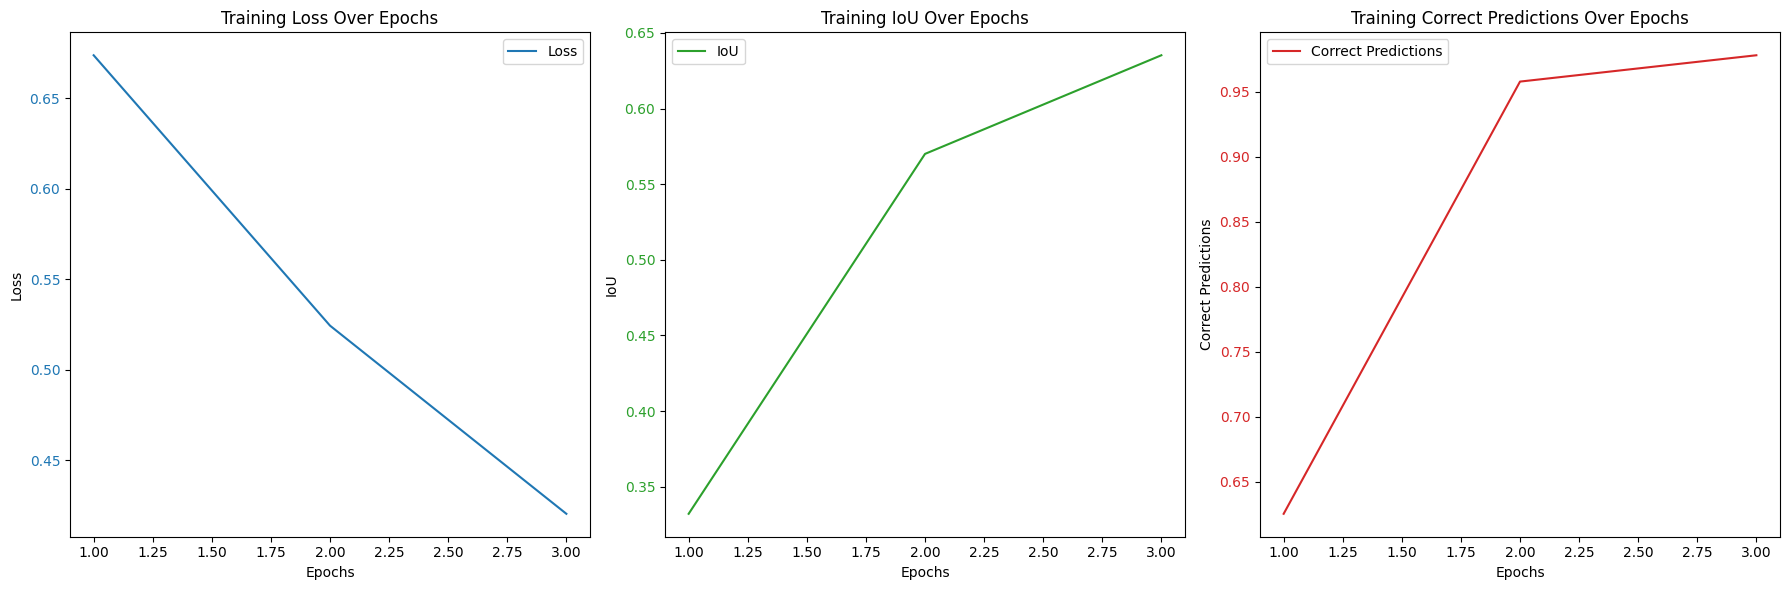

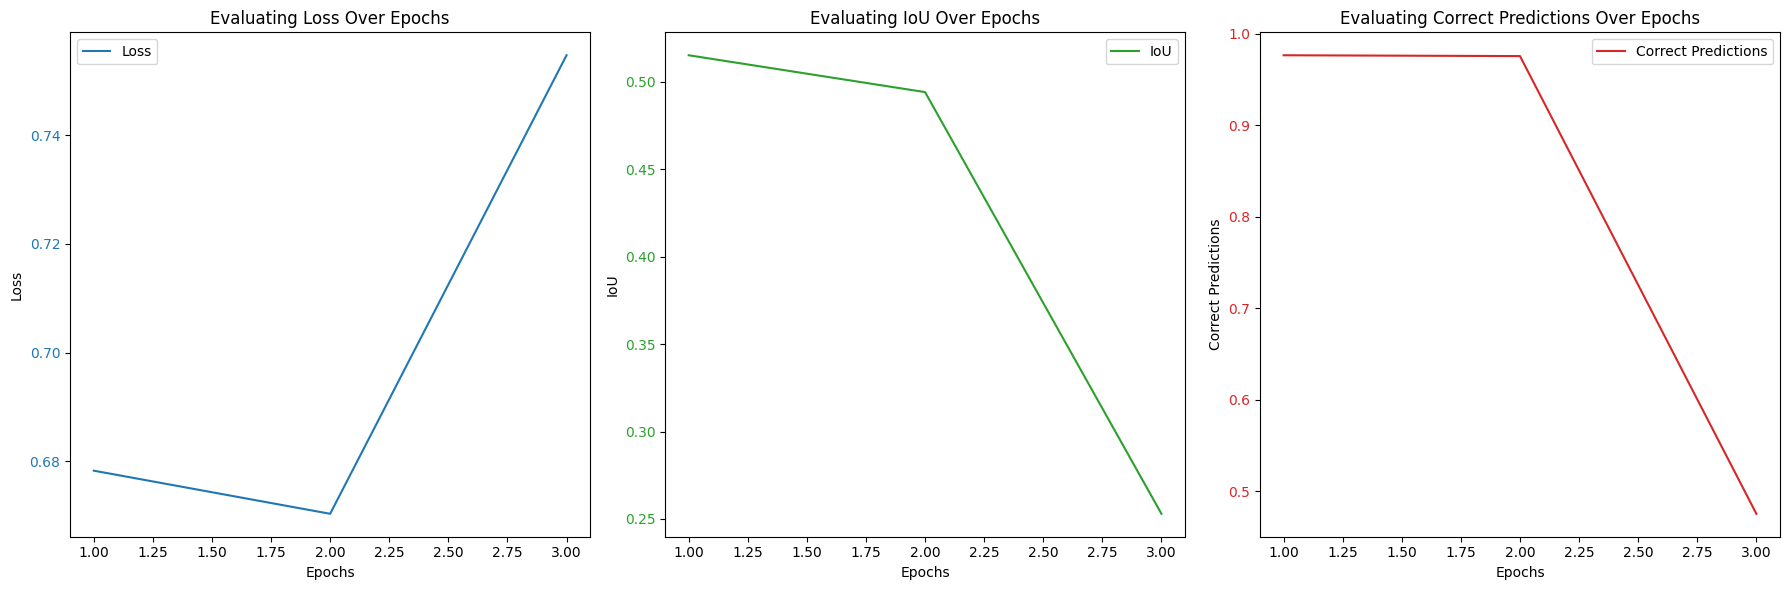

In [6]:
# RUN THIS CELL FOR NORMAL UNET

input_path = 'kraggle_images' # change this
batch_size = 4 # Number of samples per batch during training
max_epochs = 10
num_of_classes = 2

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

data_transforms = {
    'train': transforms.Compose([transforms.ToTensor(), normalize]),
    'validation': transforms.Compose([transforms.ToTensor(), normalize]),
}

model = UNet(3, num_of_classes)
trainer = Trainer_Wrapper(model, input_path, batch_size, max_epochs, num_of_classes)
trainer.begin_train()

weight_dir = input_path + "/weights"
filename = 'unet_best_weight.pth'
save_path = os.path.join(weight_dir, filename)
torch.save(trainer.model.state_dict(), save_path)

In [12]:
# RUN THIS CELL FOR BILINEAR UNET

input_path = 'kraggle_images/bw_unet_test' # change this
batch_size = 4 # Number of samples per batch during training
max_epochs = 25
num_of_classes = 2

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

data_transforms = {
    'train': transforms.Compose([transforms.ToTensor(), normalize]),
    'validation': transforms.Compose([transforms.ToTensor(), normalize]),
}

model = UNet(3, num_of_classes, True)
trainer = Trainer_Wrapper(model, input_path, batch_size, max_epochs, num_of_classes)

In [ ]:
trainer.begin_train()

weight_dir = input_path + "/weights"
filename = 'unet_bilinear_best_weight.pth'
save_path = os.path.join(weight_dir, filename)
torch.save(trainer.model.state_dict(), save_path)

In [20]:
model = UNet(3, 2)

save_path = 'kraggle_images/weights/unet_best_weight.pth'
if os.path.isfile(save_path):
    name, ext = os.path.splitext(save_path)
    assert ext == '.pkl' or '.pth', 'Only .pth and .pkl files supported.'
    print('Resuming training, loading {}...'.format(save_path))
    print(model.load_state_dict(torch.load(save_path, map_location=lambda storage, loc: storage)))

Resuming training, loading kraggle_images/weights/unet_best_weight.pth...


C:\Users\bigda\AppData\Local\Temp\ipykernel_12200\2120528375.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  print(model.load_state_dict(torch.load(save_path, map_locati

RuntimeError: PytorchStreamReader failed reading zip archive: invalid header or archive is corrupted